In [50]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [52]:
# Loading the dataset 
data = pd.read_excel('Pune_Real_Estate_Data_1.xlsx')

In [54]:
# Checking the first few rows of the dataset
print("First 5 rows of the dataset:")
print(data.head())

# Checking basic information about the dataset
print("\nBasic Information about the dataset:")
print(data.info())

# Checking for missing values in each column
print("\nMissing values in each column:")
print(data.isnull().sum())

# Checking the summary statistics of numerical features
print("\nSummary statistics of numerical columns:")
print(data.describe())

# Check for duplicates if there in our data
duplicate_rows = data.duplicated()
num_duplicates = duplicate_rows.sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Drop duplicates if they exist
if num_duplicates > 0:
    data = data.drop_duplicates()
    print(f"Duplicates removed. New dataset size: {data.shape}")

First 5 rows of the dataset:
   Sr. No.                  Location   Sub-Area Propert Type  \
0        1  Pune, Maharashtra, India    Bavdhan        1 BHK   
1        2  Pune, Maharashtra, India    Bavdhan        2 BHK   
2        3  Pune, Maharashtra, India    Bavdhan        3 BHK   
3        4  Pune, Maharashtra, India    Bavdhan  3 BHK Grand   
4        5  Pune, Maharashtra, India  Mahalunge         2BHK   

  Property Area in Sq. Ft. Price in lakhs  Price in Millions  \
0                      492             39                3.9   
1                      774             65                6.5   
2                      889             74                7.4   
3                     1018             89                8.9   
4                      743             74                7.4   

         Company Name TownShip Name/ Society Name  \
0  Shapoorji Paloonji                     Vanaha    
1  Shapoorji Paloonji                     Vanaha    
2  Shapoorji Paloonji                     

### OBSERVATIONS
1. Column wise observations:
2. Location, Sub Area, Property are categorical, hence need to perform one-hot/ label encoding- accordingly.
3. Property Area should be numerical but given in string(object) type. Hence need to change that
4. Need to change coloumns: clubhouse, school/university, hospital, mall, park, pool, gym etc into binary (0 or 1)
5. Missing Values:
6. 149/200- Total TownShip Area in Acres are missing, hence need to drop that column.
6. 1- missing value in our Target variable ['Price in Millions'],hence dropping, The corresponding value in Price in lakhs missing.
8. dropping columns : Sr. No., description, Total TownShip Area in Acres, Price in lakhs, Location (because all are from same state)
9. Outliers:
10. In Price in Millions: The max value is 93M is far from the 75th percentile (9.94M), suggesting potential outliers.
11. No duplicates found

## Data Cleaning & Processing

In [58]:
#Data Cleaning & Processing
# Step 1: Drop 'Total TownShip Area in Acres' due to high missing values, sr no, description, location
data = data.drop(columns=['Total TownShip Area in Acres'])
data= data.drop(columns=['Sr. No.'])
data= data.drop(columns=['Description'])
data = data.drop(columns=['Location'])

# Step 2: Drop the row where 'Price in Millions' is NULL (and 'Price in lakhs' is also NULL)
data = data.dropna(subset=['Price in Millions'])

# Step 3: Drop 'Price in lakhs' since we will work only with 'Price in Millions'
data = data.drop(columns=['Price in lakhs'])

# Step 4: Convert amenities (Yes/No) to binary after ensuring all values are strings
binary_columns = [
    'ClubHouse', 'School / University in Township ', 'Hospital in TownShip',
    'Mall in TownShip', 'Park / Jogging track', 'Swimming Pool', 'Gym'
]
# Convert Yes/No to binary (1 for Yes, 0 for No)
data[binary_columns] = data[binary_columns].applymap(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)

# Step 5: Standardize text by capitalizing the first letter of each word for my columns
columns_to_standardize = ['Sub-Area', 'Company Name', 'TownShip Name/ Society Name']

for col in columns_to_standardize:
    data[col] = data[col].str.strip().str.title()

#step 6: Renaming the column as it has mispelled 
data.rename(columns={'Propert Type': 'Property Type'}, inplace=True)

#step 7: changing the property type from string to float
# Function to convert property types to numeric values
def convert_property_type(value):
    value = str(value).strip().lower()  # Standardize to lowercase and remove extra spaces
    
    # Handle "Shop" directly
    if 'shop' in value:
        return 0

    # Clean the string by removing 'bhk' and spaces
    value_cleaned = value.replace(" ", "").replace("bhk", "").lower()
    
    # Handle values like "2+2 BHK" (after cleaning the string)
    if '+' in value_cleaned:
        # Split the string on "+" and convert the parts into float
        parts = [float(x.strip()) for x in value_cleaned.split('+')]
        return sum(parts)

    # Match and return the number if it's valid (handles cases like '1BHK', '2 bhk', etc.)
    match = re.match(r"(\d+(\.\d+)?)", value_cleaned)  # Match digits, possibly with a decimal
    if match:
        return float(match.group(1))  # Return the numeric part as float
    
    # Return NaN if it doesn't match any valid format
    return np.nan   

# Apply the conversion to the 'Property Type' column
data['Property Type'] = data['Property Type'].apply(convert_property_type)

#step 8:
# Function to convert property area values
def convert_property_area(value):
    # If the value is a range, e.g., '662 to 845' or '1181, 1364'
    if isinstance(value, str):
        # Handle cases like '1600 +' by converting to 1600
        if '+' in value:
            return float(value.split()[0])
        
        # Handle range cases like '662 to 845'
        match = re.match(r'(\d+)\s*to\s*(\d+)', value)
        if match:
            return (float(match.group(1)) + float(match.group(2))) / 2
        
        # Handle cases like '1181, 1364'
        match_commas = re.match(r'(\d+)[,]\s*(\d+)', value)
        if match_commas:
            return (float(match_commas.group(1)) + float(match_commas.group(2))) / 2

    # If it's a number (float or integer), return it as is
    try:
        return float(value)
    except ValueError:
        return np.nan  # Return NaN for anything not matching the above patterns


# Apply the conversion to the 'Property Area in Sq. Ft.' column
data['Property Area in Sq. Ft.'] = data['Property Area in Sq. Ft.'].apply(convert_property_area)


/var/folders/vm/0dzyd5yx58lbxk82hl1581dh0000gn/T/ipykernel_34496/2264591307.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[binary_columns] = data[binary_columns].applymap(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)


## Handling Outliers

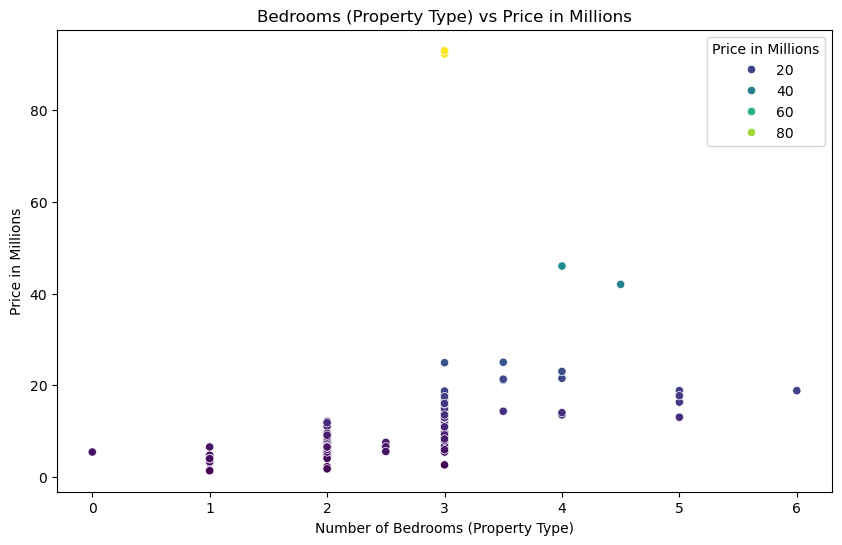

In [61]:
#Handling Outliers
# Plot: Bedrooms vs. Price in Millions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Property Type', y='Price in Millions', hue='Price in Millions', palette='viridis')
plt.title('Bedrooms (Property Type) vs Price in Millions')
plt.xlabel('Number of Bedrooms (Property Type)')
plt.ylabel('Price in Millions')
plt.show()

#Remove rows where 'Price in Millions' > 40
data = data[data['Price in Millions'] <= 40]


## Observations
1. In "price in Millions" column, i see that there are 4 outliers, its a error while entering, they entered the same value of Area and price.

## EDA

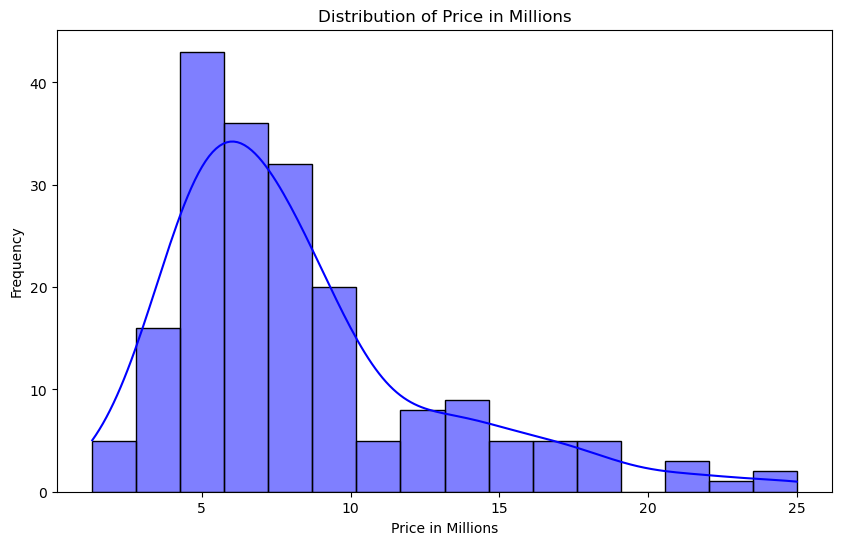

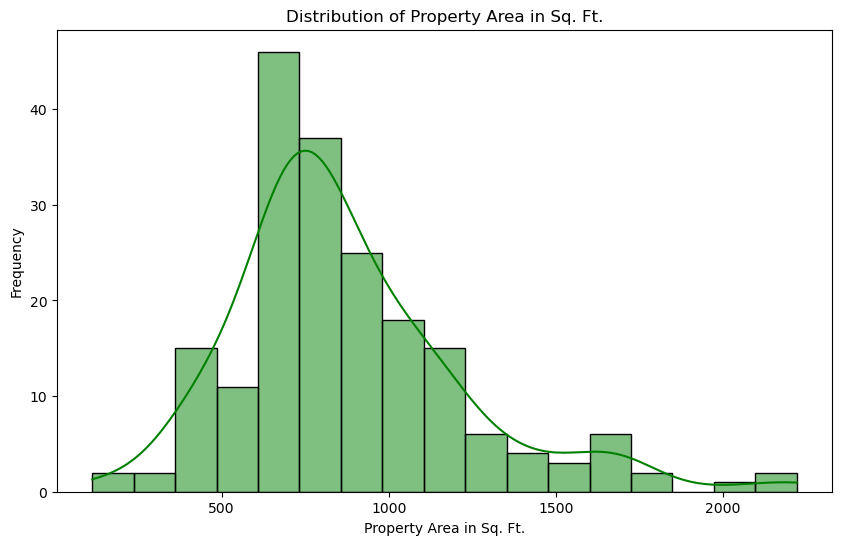

In [65]:
# Plot histogram for 'Price in Millions'
plt.figure(figsize=(10, 6))
sns.histplot(data['Price in Millions'], kde=True, color='blue')
plt.title('Distribution of Price in Millions')
plt.xlabel('Price in Millions')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'Property Area in Sq. Ft.'
plt.figure(figsize=(10, 6))
sns.histplot(data['Property Area in Sq. Ft.'], kde=True, color='green')
plt.title('Distribution of Property Area in Sq. Ft.')
plt.xlabel('Property Area in Sq. Ft.')
plt.ylabel('Frequency')
plt.show()


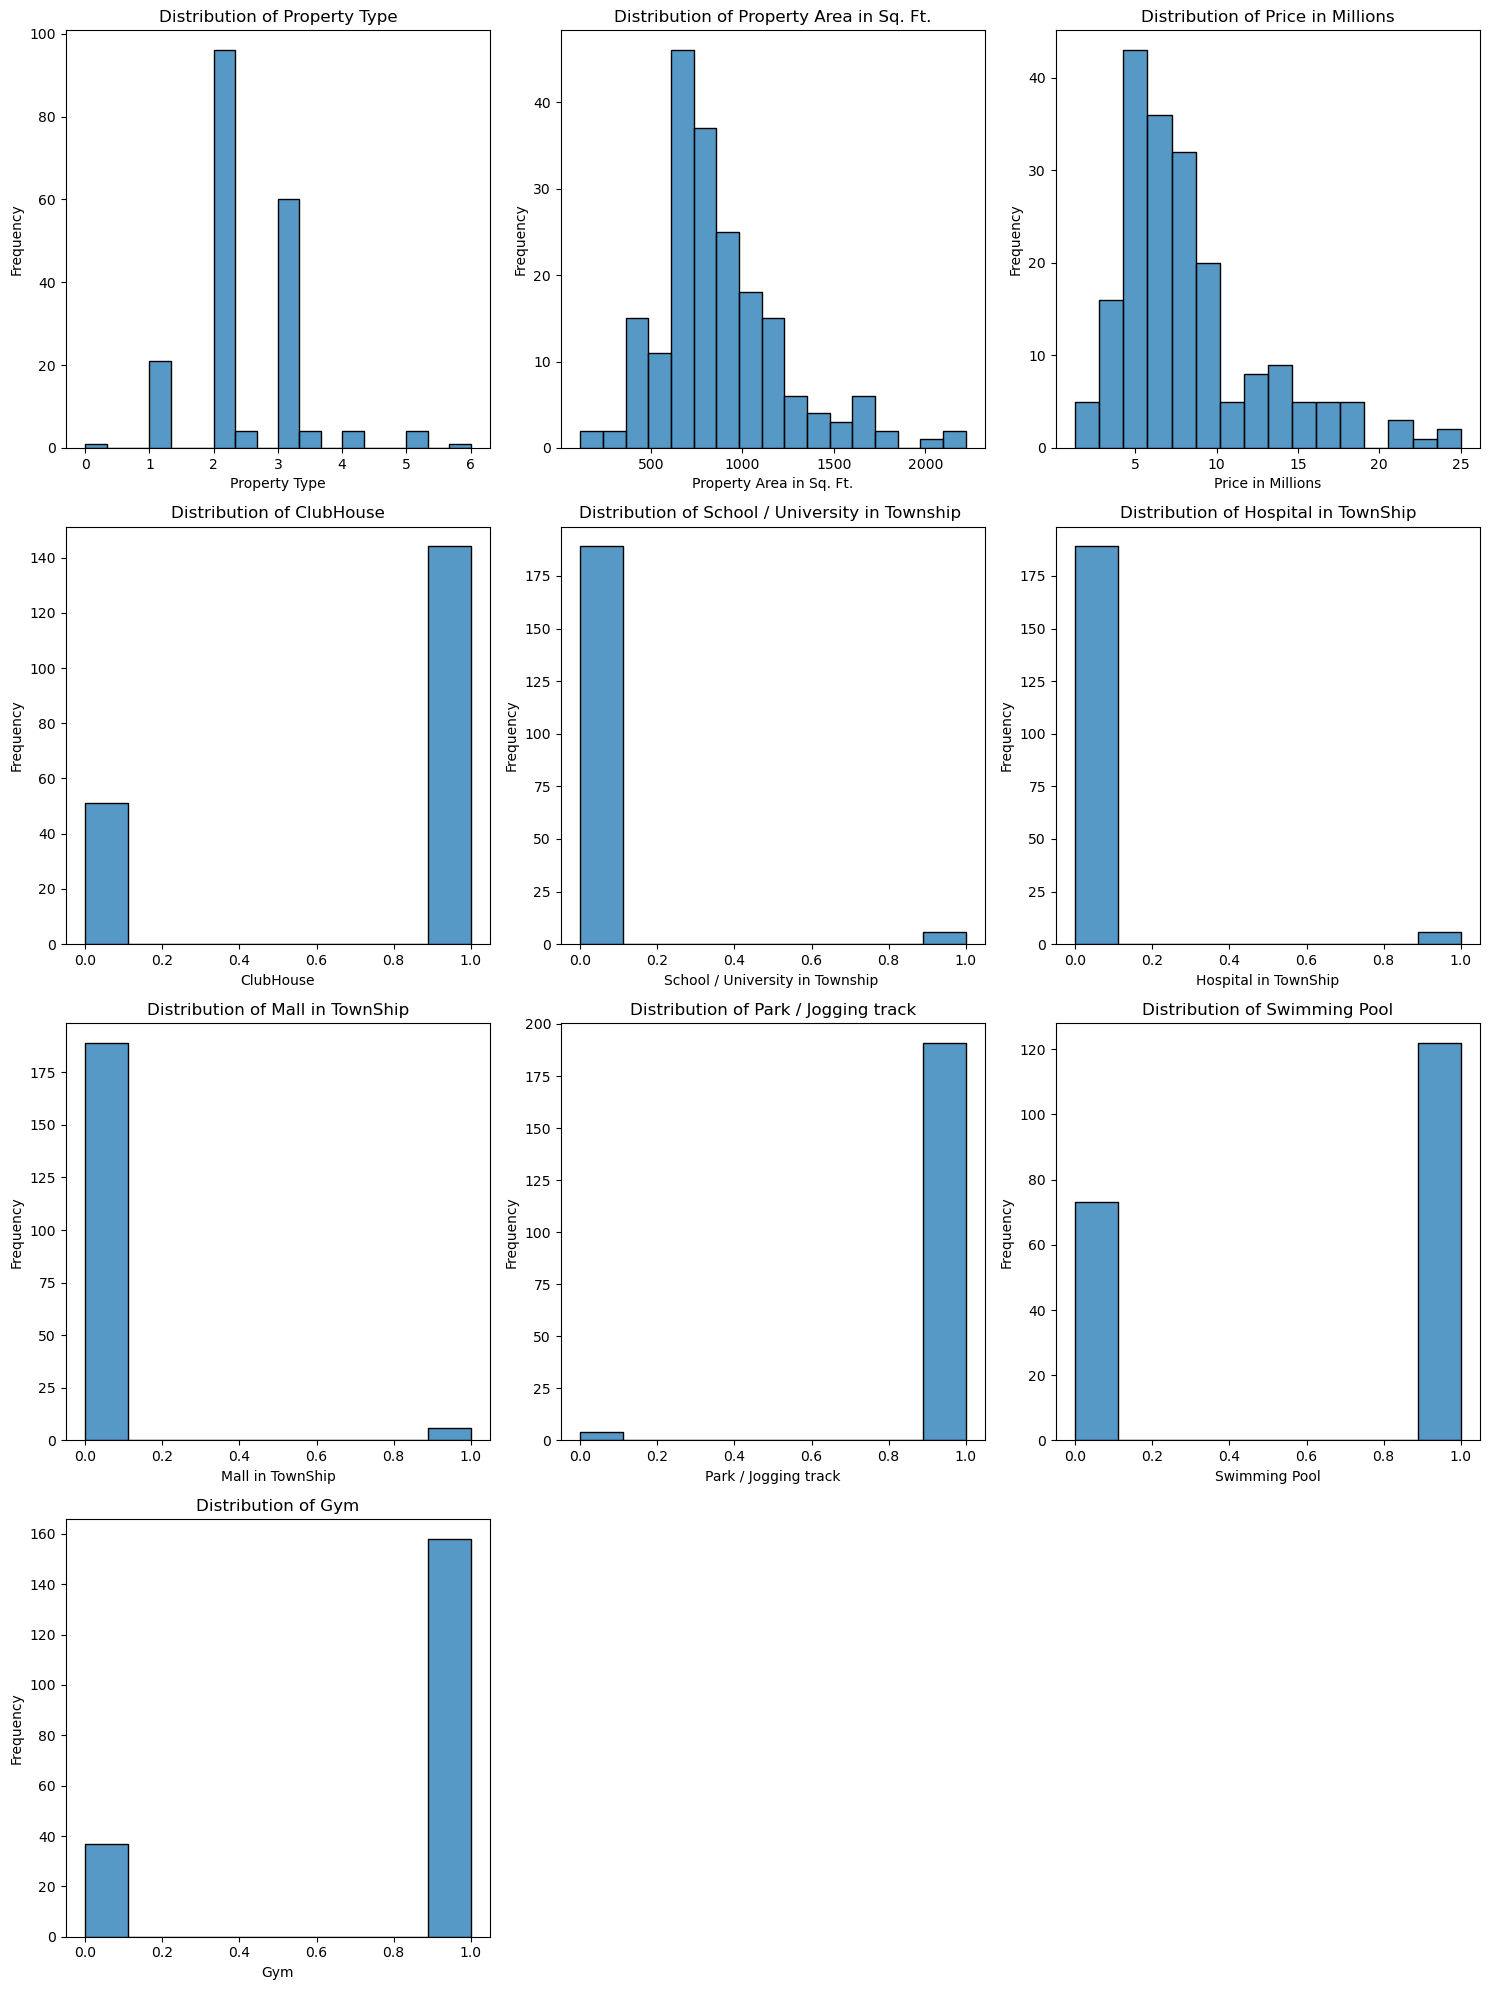

In [67]:
# Select numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Determine the grid size
n_cols = 3  # Number of columns in the grid
n_rows = -(-len(numerical_columns) // n_cols)  # Calculate rows needed (ceiling division)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot distributions
for i, col in enumerate(numerical_columns):
    sns.histplot(data[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide unused subplots
for j in range(len(numerical_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


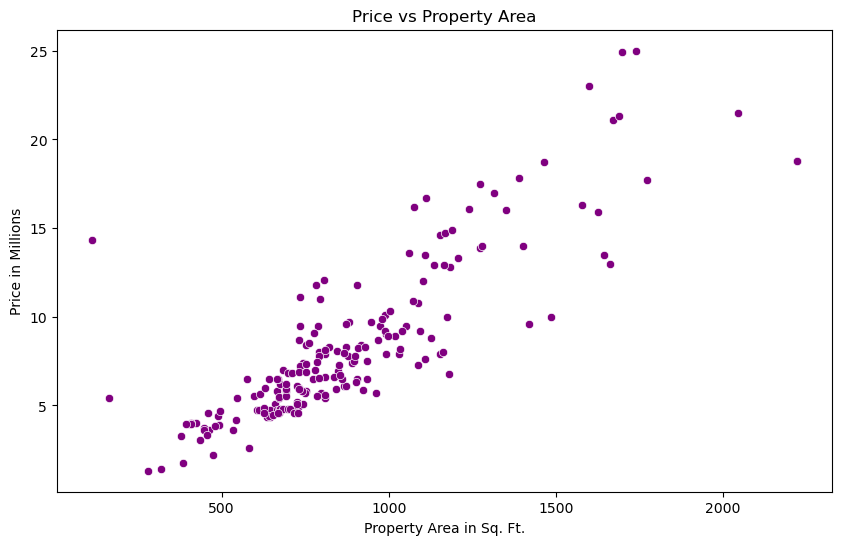

In [69]:
# Scatter plot for 'Price vs Property Area'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Property Area in Sq. Ft.', y='Price in Millions', color='purple')
plt.title('Price vs Property Area')
plt.xlabel('Property Area in Sq. Ft.')
plt.ylabel('Price in Millions')
plt.show()


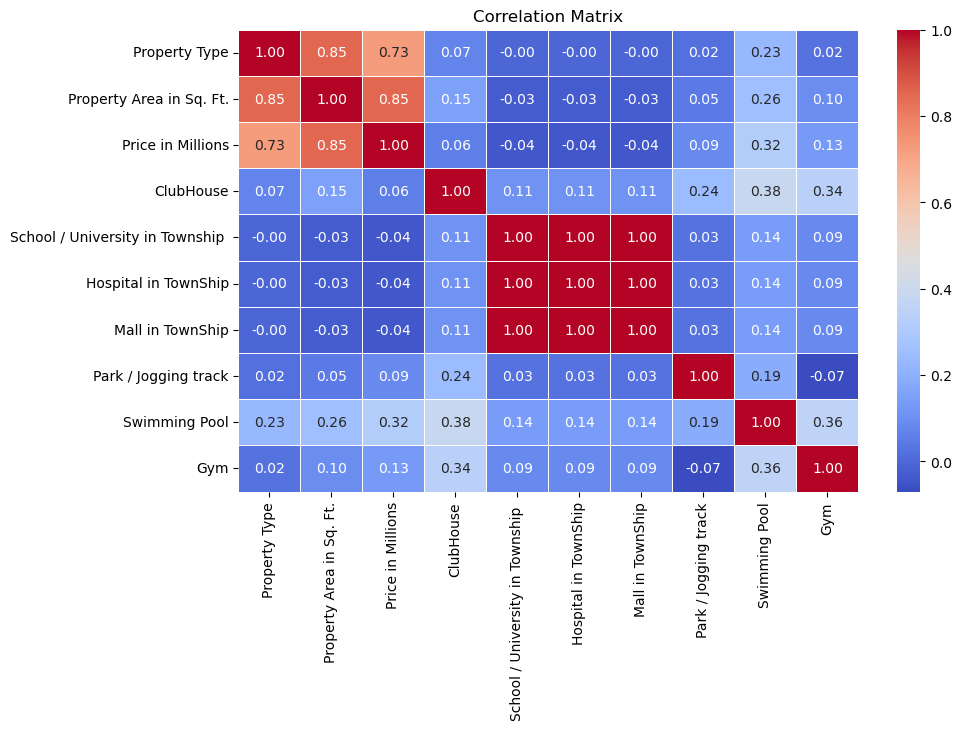

In [71]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


## Observations

1. Property Area in Sq. Ft. and Price in Millions: There is a strong positive correlation (0.85) between Property Area in Sq. Ft. and Price in Millions. This suggests that larger properties tend to have higher prices.
2. Property Type and Price in Millions: There is a moderate positive correlation (0.73) between Property Type and Price in Millions, indicating that more expensive property types are associated with higher prices.
3. Swimming Pool and Price in Millions: A moderate positive correlation (0.32) is observed between Swimming Pool and Price in Millions, suggesting that properties with a swimming pool tend to have higher prices.
4. Gym and Swimming Pool: Gym and Swimming Pool have a positive correlation (0.36), meaning properties with a gym also tend to have a swimming pool, though this is not a very strong correlation.
5. Amenities (ClubHouse, School, Hospital, Mall, Park/Jogging Track, Swimming Pool, Gym): There are low correlations between Price in Millions and the other amenities (ClubHouse, School, Hospital, Mall, Park, Gym). This suggests that amenities like the clubhouse, school, hospital, etc., don't have a strong direct relationship with the price, though some individual correlations (like with Swimming Pool and Gym) are slightly stronger.

## Feature Engineering

In [76]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


# Initialize a new LabelEncoder for each column
label_encoder_sub_area = LabelEncoder()
label_encoder_company_name = LabelEncoder()
label_encoder_township_name = LabelEncoder()

# Fit and transform the data for each column
data['Sub-Area'] = label_encoder_sub_area.fit_transform(data['Sub-Area'])
data['Company Name'] = label_encoder_company_name.fit_transform(data['Company Name'])
data['TownShip Name/ Society Name'] = label_encoder_township_name.fit_transform(data['TownShip Name/ Society Name'])

# Generate the mappings
sub_area_mapping = dict(zip(label_encoder_sub_area.classes_, label_encoder_sub_area.transform(label_encoder_sub_area.classes_)))
company_name_mapping = dict(zip(label_encoder_company_name.classes_, label_encoder_company_name.transform(label_encoder_company_name.classes_)))
township_name_mapping = dict(zip(label_encoder_township_name.classes_, label_encoder_township_name.transform(label_encoder_township_name.classes_)))

# Display the mappings- displayed because i want to put them in drop down menu end point.
print("Sub-Area Mapping:", sub_area_mapping)
print("Company Name Mapping:", company_name_mapping)
print("TownShip Name/Society Name Mapping:", township_name_mapping)


# Initialize the scaler
scaler = StandardScaler()

# Only scale the 'Property Area in Sq. Ft.' feature
data['Property Area in Sq. Ft.'] = scaler.fit_transform(data[['Property Area in Sq. Ft.']])

Sub-Area Mapping: {'Akurdi': 0, 'Balewadi': 1, 'Baner': 2, 'Bavdhan': 3, 'Bavdhan Budruk': 4, 'Bt Kawade Rd': 5, 'Dhanori': 6, 'Hadapsar': 7, 'Handewadi': 8, 'Hinjewadi': 9, 'Karvanagar': 10, 'Kayani Nagar': 11, 'Keshav Nagar': 12, 'Kharadi': 13, 'Kirkatwadi Sinhagad Road': 14, 'Kiwale': 15, 'Koregaon Park': 16, 'Koregoan': 17, 'Lonavala': 18, 'Magarpatta': 19, 'Mahalunge': 20, 'Manjri': 21, 'Mohammadwadi': 22, 'Mundhwa': 23, 'Nibm': 24, 'Pimpri Pune': 25, 'Pisoli': 26, 'Ravet': 27, 'Susgaon': 28, 'Talegoan': 29, 'Tathawade': 30, 'Undri': 31, 'Vimannagar': 32, 'Wadgaon Sheri': 33}
Company Name Mapping: {'Ace Constructions': 0, 'Anp Corp': 1, 'Bhaktamar Realities': 2, 'Calyx Spaces': 3, 'Dolphin Group': 4, 'Godrej Properties': 5, 'Jhala Group': 6, 'Kalpataru': 7, 'Keystone Landmark': 8, 'Kohinoor Group': 9, 'Kundan Spaces': 10, 'Lush Life': 11, 'Maha Anand Pinnac Associates': 12, 'Majestique Landmarks': 13, 'Mantra Properties': 14, 'Nirman Developers': 15, 'Oxy Buildcorp': 16, 'Porwal  

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split


X = data.drop(columns=['Price in Millions'])  # Replace 'target_column' with your actual target column name
y = data['Price in Millions']  # Replace 'target_column' with your actual target column name

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize the model
model = GradientBoostingRegressor()

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print(f"Best Gradient Boosting Parameters: {best_params}")

# Bootstrap procedure for prediction intervals
n_iterations = 1000
predictions = np.zeros((n_iterations, len(X_test)))

for i in range(n_iterations):
    # Resample training data with replacement
    X_train_resample, y_train_resample = resample(X_train, y_train, n_samples=len(X_train), random_state=i)
    
    # Fit the model on resampled data
    best_model.fit(X_train_resample, y_train_resample)
    
    # Predict on the test set
    predictions[i] = best_model.predict(X_test)

# Calculate the 0th and 100th percentiles for prediction intervals
lower_bound = np.percentile(predictions, 0, axis=0)
upper_bound = np.percentile(predictions, 100, axis=0)

# Calculate the point estimates (mean prediction)
point_estimate = np.mean(predictions, axis=0)

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model on the test set
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"\nGradient Boosting Evaluation Metrics:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")



Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.8}

Gradient Boosting Evaluation Metrics:
MAE: 1.4815429520648438
MSE: 5.503198397194976
RMSE: 2.34588968137783
R²: 0.793428255992214


In [29]:
# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred (Point Estimate)': point_estimate,
    'Prediction Interval (Lower)': lower_bound,
    'Prediction Interval (Upper)': upper_bound
})

results_df

,y_test,y_pred (Point Estimate),Prediction Interval (Lower),Prediction Interval (Upper)
142,5.800,5.957884,4.587580,8.312091
16,5.800,5.137798,2.897688,6.910264
159,8.900,9.159223,7.137690,11.580321
100,8.500,8.012006,6.321490,8.940847
70,4.934,4.881363,3.408113,7.776792
157,5.900,6.140107,4.584070,7.532319
56,4.550,4.267243,3.111163,5.298453
15,4.000,3.382700,0.919318,4.918246
116,12.100,9.180887,5.235879,11.484246
115,11.800,9.074094,5.009402,11.215821


In [31]:
import pickle
# Save the trained model for later use
with open('gradient_boosting_model3.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

# Save X_train and y_train for later use
with open('X_train.pkl', 'wb') as x_file:
    pickle.dump(X_train, x_file)

with open('y_train.pkl', 'wb') as y_file:
    pickle.dump(y_train, y_file)

In [33]:
print(type(model))

<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


## ROUGH

                          MAE        MSE      RMSE        R²
Linear Regression    1.968049  11.717339  3.423060  0.560170
Decision Tree        1.532795   9.624510  3.102339  0.638728
Random Forest        1.644983   7.944608  2.818618  0.701786
K-Nearest Neighbors  2.209933   9.372310  3.061423  0.648195
SVM                  2.228480  12.709527  3.565042  0.522927
Gradient Boosting    1.563144   6.556015  2.560472  0.753909


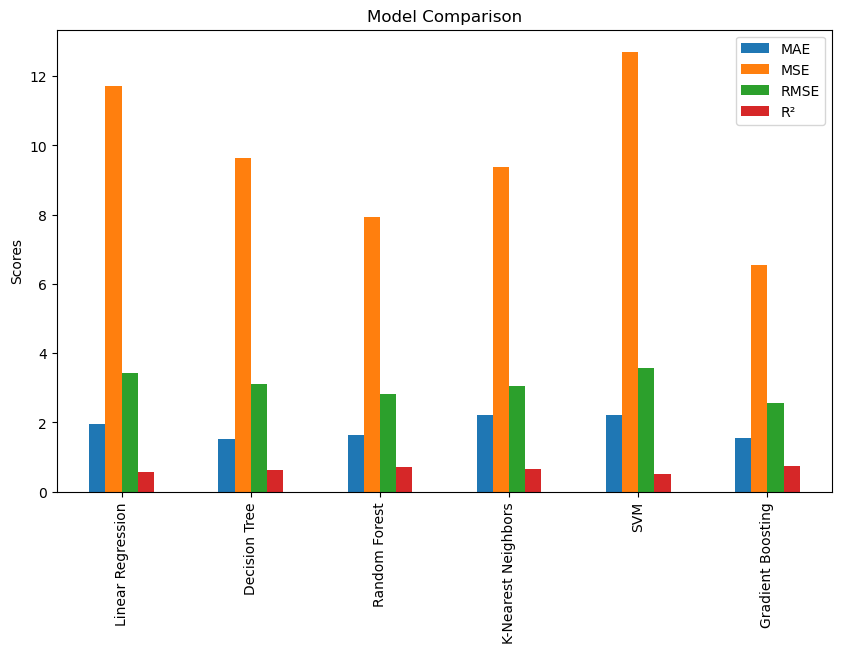

In [229]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
# Assuming 'data' is your DataFrame and 'target_column' is the column you're predicting
X = data.drop(columns=['Price in Millions'])  # Replace 'target_column' with your actual target column name
y = data['Price in Millions']  # Replace 'target_column' with your actual target column name

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature data (important for models like SVM, KNN, Linear Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize regression models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'SVM': SVR(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Train models and evaluate them
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results[model_name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

# Display the results
results_df = pd.DataFrame(results).T
print(results_df)

# Optional: Visualizing the performance of each model
results_df.plot(kind='bar', figsize=(10, 6), title='Model Comparison')
plt.ylabel('Scores')
plt.show()
